In [1]:
import torch
from transformers import AutoConfig, AutoImageProcessor, AutoModelForVision2Seq, AutoProcessor
import time
import numpy as np
import cv2
import textwrap
from PIL import Image, ImageDraw, ImageFont
import enum

import requests
from io import BytesIO
from PIL import Image

import os

/zfsauton2/home/hshah2/miniconda/envs/finetune/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-07 00:55:41.951833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744001742.414072 3325090 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744001742.568120 3325090 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 00:55:44.958021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in pe

In [2]:
#@title Define utils

def split_reasoning(text, tags):
    new_parts = {None: text}

    for tag in tags:
        parts = new_parts
        new_parts = dict()

        for k, v in parts.items():
            if tag in v:
                s = v.split(tag)
                new_parts[k] = s[0]
                new_parts[tag] = s[1]
                # print(tag, s)
            else:
                new_parts[k] = v

    return new_parts

class CotTag(enum.Enum):
    TASK = "TASK:"
    PLAN = "PLAN:"
    VISIBLE_OBJECTS = "VISIBLE OBJECTS:"
    SUBTASK_REASONING = "SUBTASK REASONING:"
    SUBTASK = "SUBTASK:"
    MOVE_REASONING = "MOVE REASONING:"
    MOVE = "MOVE:"
    GRIPPER_POSITION = "GRIPPER POSITION:"
    ACTION = "ACTION:"


def get_cot_tags_list():
    return [
        CotTag.TASK.value,
        CotTag.PLAN.value,
        CotTag.VISIBLE_OBJECTS.value,
        CotTag.SUBTASK_REASONING.value,
        CotTag.SUBTASK.value,
        CotTag.MOVE_REASONING.value,
        CotTag.MOVE.value,
        CotTag.GRIPPER_POSITION.value,
        CotTag.ACTION.value,
    ]

def name_to_random_color(name):
    return [(hash(name) // (256**i)) % 256 for i in range(3)]




def draw_gripper(img, pos_list, img_size=(640, 480)):
    for i, pos in enumerate(reversed(pos_list)):
        pos = resize_pos(pos, img_size)
        scale = 255 - int(255 * i / len(pos_list))
        cv2.circle(img, pos, 6, (0, 0, 0), -1)
        cv2.circle(img, pos, 5, (scale, scale, 255), -1)

def get_metadata(reasoning):
    metadata = {"gripper": [[0, 0]], "bboxes": dict()}

    if f" {CotTag.GRIPPER_POSITION.value}" in reasoning:
        gripper_pos = reasoning[f" {CotTag.GRIPPER_POSITION.value}"]
        gripper_pos = gripper_pos.split("[")[-1]
        gripper_pos = gripper_pos.split("]")[0]
        gripper_pos = [int(x) for x in gripper_pos.split(",")]
        gripper_pos = [(gripper_pos[2 * i], gripper_pos[2 * i + 1]) for i in range(len(gripper_pos) // 2)]
        metadata["gripper"] = gripper_pos

    if f" {CotTag.VISIBLE_OBJECTS.value}" in reasoning:
        for sample in reasoning[f" {CotTag.VISIBLE_OBJECTS.value}"].split("]"):
            obj = sample.split("[")[0]
            if obj == "":
                continue
            coords = [int(n) for n in sample.split("[")[-1].split(",")]
            metadata["bboxes"][obj] = coords

    return metadata

def resize_pos(pos, img_size):
    return [(x * size) // 256 for x, size in zip(pos, img_size)]

def draw_bboxes(img, bboxes, img_size=(640, 480)):
    for name, bbox in bboxes.items():
        show_name = name
        # show_name = f'{name}; {str(bbox)}'

        cv2.rectangle(
            img,
            resize_pos((bbox[0], bbox[1]), img_size),
            resize_pos((bbox[2], bbox[3]), img_size),
            name_to_random_color(name),
            1,
        )
        cv2.putText(
            img,
            show_name,
            resize_pos((bbox[0], bbox[1] + 6), img_size),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
            cv2.LINE_AA,
        )

In [3]:
device = "cuda:0"

# Load Processor & VLA
# NOTE: Requires ~15 GB of GPU memory, but can enable load_in_4bit to reduce
# model memory usage to ~5 GB
path_to_converted_ckpt = "Embodied-CoT/ecot-openvla-7b-bridge"
processor = AutoProcessor.from_pretrained(path_to_converted_ckpt, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    path_to_converted_ckpt,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    # [Optional] Set `load_in_4bit=True` if not enough GPU memory + run `pip install bitsandbytes`
    # Then, comment out `.to(device)`
).to(device)

/zfsauton2/home/hshah2/miniconda/envs/finetune/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/Embodied-CoT/ecot-openvla-7b-bridge:
- processing_prismatic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/zfsauton2/home/hshah2/miniconda/envs/finetune/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A new version of the following files was downloaded from https://hugg

In [4]:
url = 'https://raw.githubusercontent.com/MichalZawalski/embodied-CoT/main/test_obs.png'
page = requests.get(url)
image = Image.open(BytesIO(page.content))

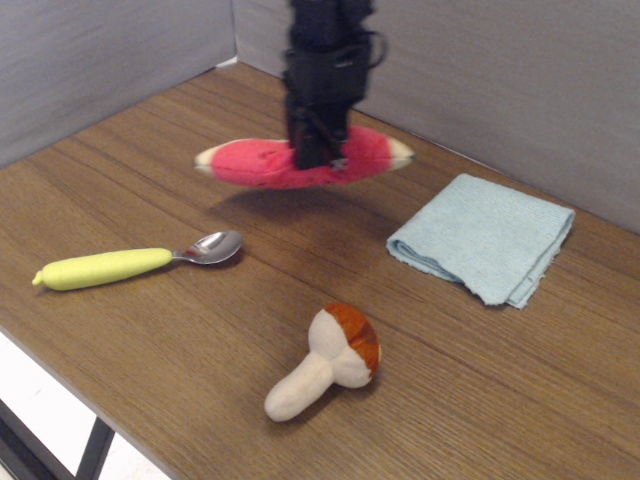

In [5]:
image

In [6]:
# Create prompt
SYSTEM_PROMPT = (
    "A chat between a curious user and an artificial intelligence assistant. "
    "The assistant gives helpful, detailed, and polite answers to the user's questions."
)

def get_openvla_prompt(instruction: str) -> str:
    return f"{SYSTEM_PROMPT} USER: What action should the robot take to {instruction.lower()}? ASSISTANT: TASK:"

INSTRUCTION = "place the watermelon on the towel"
prompt = get_openvla_prompt(INSTRUCTION)
print(prompt.replace(". ", ".\n"))

A chat between a curious user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions.
USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK:


In [7]:
# Run inference
inputs = processor(prompt, image).to(device, dtype=torch.bfloat16)

# Run OpenVLA Inference
start_time = time.time()

torch.manual_seed(0)
action, generated_ids = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False, max_new_tokens=1024)
generated_text = processor.batch_decode(generated_ids)[0]
print(f"Time: {time.time() - start_time:.4f} || Action: {action}")

Time: 22.3188 || Action: [ 0.01321167 -0.02891499  0.00209718  0.0017769  -0.02757519 -0.05003245
  0.        ]


In [8]:
generated_text

"<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK: Place the watermelon on the towel. PLAN: Move to the watermelon, grasp it, move to the towel, release the watermelon. SUBTASK REASONING: The watermelon is grasped and needs to be moved to the towel. SUBTASK: Move to the towel. MOVE REASONING: The towel is to the right of the watermelon, so the robot needs to move right to reach it. MOVE: Move right. GRIPPER POSITION: [113, 91] VISIBLE OBJECTS: a pink watermelon [65, 84, 135, 110], a pink watermelon [66, 83, 135, 109], the scene [4, 0, 243, 249], a yellow spoon [19, 120, 98, 150], the scene towel [156, 99, 230, 157], a wooden table [19, 58, 223, 244] ACTION: 話双̍Ħ米米Ÿ</s>"

In [9]:
#@title Visualize reasoning and image
tags = [f" {tag}" for tag in get_cot_tags_list()]
reasoning = split_reasoning(generated_text, tags)
text = [tag + reasoning[tag] for tag in [' TASK:',' PLAN:',' SUBTASK REASONING:',' SUBTASK:',
                                        ' MOVE REASONING:',' MOVE:', ' VISIBLE OBJECTS:', ' GRIPPER POSITION:'] if tag in reasoning]
metadata = get_metadata(reasoning)
bboxes = {}
for k, v in metadata["bboxes"].items():
    if k[0] == ",":
        k = k[1:]
    bboxes[k.lstrip().rstrip()] = v

caption = ""
for t in text:
    wrapper = textwrap.TextWrapper(width=80, replace_whitespace=False)
    word_list = wrapper.wrap(text=t)
    caption_new = ''
    for ii in word_list[:-1]:
        caption_new = caption_new + ii + '\n      '
    caption_new += word_list[-1]

    caption += caption_new.lstrip() + "\n\n"

base = Image.fromarray(np.ones((480, 640, 3), dtype=np.uint8) * 255)
draw = ImageDraw.Draw(base)
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
font = ImageFont.truetype(font_path, size=14)
color = (0,0,0) # RGB
draw.text((30, 30), caption, color, font=font)

img_arr = np.array(image)
draw_gripper(img_arr, metadata["gripper"])
draw_bboxes(img_arr, bboxes)

text_arr = np.array(base)

reasoning_img = Image.fromarray(np.concatenate([img_arr, text_arr], axis=1))

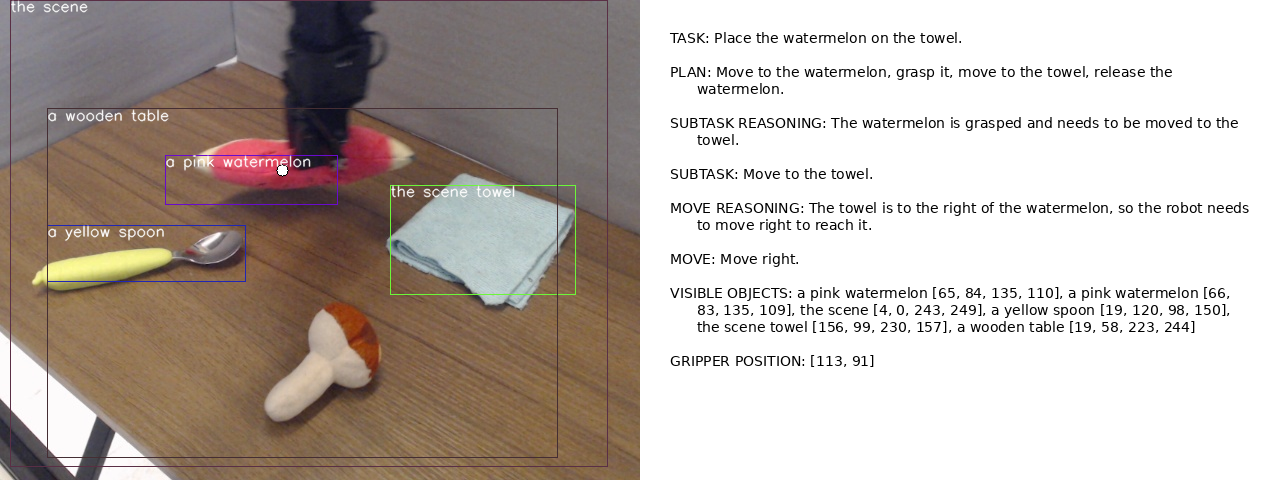

In [10]:
# Visualize reasoning image!
reasoning_img